## PART 1

In this frst part, we want to randomly retrieve tweets posted by people in the early stage of the pandemic in order to analyse how COVID-19 affected people's interests and the role of social media as communication platforms. The way we use to retrieve tweets
aims at obtaining a sample which is the least possible biased. After retrieving data for each country (in this first analysis
we start with Serbia and Italy, out homelands, to test the scalability and feasibility of our ideas), we want to classify them according to
the topic they present. We are interested in analysing which have been the most discussed topics to see if we get result
similar to those shown in CoronaWiki dataset. We think this is a good way to start analysing how people's interests shifted, how people reacted to the situation and how communication has been affected by COVID-19.

Please notice that the choice of focusing on the first period of the pandemic is also due to the fact that, in Task3, we are willing to test whether a higher or lower interest in COVID in the period preceding the lockdown might have been a crucial factor to slow the infection rate after the lockdown was set. To compute this analysis, we need to collect as many data as possible regarding the early stage of the pandemic and we are not allowed to use data regarding successive stages of the pandemic. 

In [1]:
# Useful libraries
import pandas as pd
import json
import re
import pickle
from datetime import datetime, timedelta

# Twitter library
import tweepy

# Math libraries
import numpy as np

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob # to compute sentiment analysis on each tweet
import translators as ts

nltk.download('stopwords')

# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()


Using state Vaud server backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### TWEETS DATASET CREATION - ITALY AND SERBIA

We start by creating lists containing the names of the analysed countries and the spoken languages.

In [2]:
# We define lists containing the names and the spoken languages in each country
# france, danimark, germany, italy, netherlands, normway, sweden, serbia, finland, england
total_countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB']
total_languages = ['fr','da','de','it','nl','no','sv','sr','fi','en']
analysed_countries = ['IT','RS']
analysed_languages = ['it','sr']
period_per_countries = {}

In order to compute our analysis, we need to define a period of time during the pandemic. We use pagelogs and intervention data in order to define this period of interest for each country. We retrieved data during the 3 weeks preceding the lockdown, since we are interested in analyzing human reactions and behaviour during the first stage of the pandemic.

In [3]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)

In [5]:
# Importing intervention dates for each country
interventions = pd.read_csv(data_path + 'interventions.csv', delimiter = ',',parse_dates = ['1st case','1st death','School closure',
                                                                                            'Public events banned','Lockdown','Mobility','Normalcy'])
interventions.set_index('lang',inplace = True)
interventions

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15


In [6]:
# Defining period of interest for each country. Dates refered to 3 weeks before the lockdown
lockdown_dates = [interventions.loc['it','Lockdown'],interventions.loc['sr','Lockdown']]

for idx,country in enumerate(analysed_countries):
    lang = analysed_languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates

We want to retrieve tweets on a daily basis. In order to reduce the bias in our data, we decide to retrieve tweets in different moments of the day which are randomly chosen. Since most of the activity was during the afternoon, we want to give more weights to these hours. 

In [7]:
# Defining a hour time window to retrieve data
hours = [11,12,13,14,15,16,17,18,19,20]
# We want to give more weights to part of the day closer to dinner / late afternoon. So we assign them a higher weights
weights = np.ones(len(hours)) / 15
weights[-5:] = weights[-5:]*2

Since we are interested in finding analogies between the topics discussed on Twitter and the pages visited on Wikipedia, we need to define a list of topics with respect to which we are going to classify each retrieved tweet. In order to do so, we use the file 'topics_linked.csv'. Considering that we use empath library to compute the classification of each text, we define a set of topics which is as equivalent as possible to the one reported in the file.

In [89]:
provided_topics = pd.read_csv('./Data/topics_linked.csv',delimiter = ',')
provided_topics.columns

Index(['index', 'Geography.Regions.Asia.Central Asia',
       'Geography.Regions.Europe.Eastern Europe',
       'History and Society.Military and warfare', 'Culture.Media.Television',
       'History and Society.Education', 'Culture.Media.Books',
       'Geography.Regions.Africa.Africa*', 'Culture.Visual arts.Architecture',
       'Culture.Biography.Women', 'Geography.Regions.Americas.North America',
       'STEM.STEM*', 'Culture.Performing arts', 'Culture.Literature',
       'History and Society.Politics and government',
       'Geography.Regions.Africa.Northern Africa',
       'STEM.Earth and environment', 'Geography.Regions.Africa.Central Africa',
       'STEM.Medicine & Health', 'STEM.Libraries & Information',
       'Geography.Regions.Europe.Europe*',
       'Geography.Regions.Europe.Western Europe', 'Culture.Media.Radio',
       'STEM.Space', 'Culture.Visual arts.Comics and Anime', 'STEM.Technology',
       'Culture.Internet culture', 'Culture.Media.Software',
       'Geography.R

After reading the categories offered by empath library at  https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [8]:
topics = ['help','medical_emergency','health','government','school','kill','art','play','computer',
         'home','business','religion','sports','military','music','science','fun','economics',
         'technology','philosophy','geography','tv','architecture']

We also define a list of feelings and emotions that we want to detect in each tweet to perceive the general sentiment n the population. This method performs better than a simple sentiment analysis since it better catches the semantic power of each used word.

In [9]:
emotions = ["suffering","optimism","fear","sadness","joy","anger","pain","negative_emotion","positive_emotion",
           "happiness"]

We now proceed to define two helper functions to create and import the needed dataframes. As said before, we start working on tweets posted by italian and serbian people to verify the goodness of our approach. For Milestone3, we will focus on a bigger number of countries.
Notice that, in order to filter the tweets we retrieve, we set a very specific query.

In [59]:
# Importing Twitter API keys
with open('./Data/BearerTokens.json', 'r') as f:
    bearer_tokens = json.load(f)

bearer_token_balsa = bearer_tokens['gojko']

def create_dataframe(name_country,language,period_of_interest,time_window = hours, prob = weights, skip_day = 1, subsample = None):
    
    # Initialize the stemmer
    stemmer = PorterStemmer()
    lexicon = Empath()
    # Defining a list of topics based on Coronawiki Dataset
    topics = []
    # Defining support structure
    new_data = []
    output_path = './output/'+name_country
    if subsample != None:
        output_path+= subsample
    output_path+='_tweets.pkl'
    
    # We initialize tweepy 
    client = tweepy.Client(bearer_token=bearer_token_balsa, wait_on_rate_limit=True)
    
    for idx in range(0,len(period_of_interest[name_country]), skip_day):
        # We randomly choose the time of the day to retrieve tweets
        random_hour = np.random.choice(hours,p = weights)
        date = period_of_interest[name_country][idx]
        
        # We define start and end time to retrieve (then passed as inputs for twitter.API)
        start_time = datetime(date.year,date.month,date.day,random_hour)
        end_time = datetime(date.year,date.month,date.day,random_hour+3)
        
        # We define a proper query to get tweets from the country we're interested in
        query = " place_country:{} lang:{} -is:retweet -has:links -has:media -has:images \
                                    -has:video_link -has:mentions".format(name_country,language)
        
        while True:
            tweets = client.search_all_tweets( query, max_results = 30, 
                                         start_time = start_time, end_time = end_time,
                                              tweet_fields  = ['text','context_annotations','id'])
            if tweets.data != None:
                break
            random_hour = np.random.choice(hours,p = weights)
            date = period_of_interest[name_country][idx]
            start_time = datetime(date.year,date.month,date.day,random_hour)
            end_time = datetime(date.year,date.month,date.day,random_hour+3)
        
        # We perform basic preprocessing operations on the text (translation and removal of punctuations)
        for tweet in tweets.data:
            if language != 'en':
                text = ts.google(tweet.text)
            else:
                text = tweet.text
            # We remove punctuation
            text = ("".join([ch for ch in text if ch not in string.punctuation])).lower()
            # We remove numbers
            text = re.sub("\d+", "",text).strip()
            # We compute sentiment analysis on the given text
            text_sentiment = TextBlob(text).sentiment
            text_polarity, text_subjectivity = text_sentiment.polarity, text_sentiment.subjectivity
            # We tokenize the tweet to make the work easier
            tokenized_stemmed_version = nltk.word_tokenize(text)
            tokenized_stemmed_version = [stemmer.stem(word) for word in tokenized_stemmed_version]
            # Saving new datapoint in new_data list
            if len(text) > 0:
                new_data.append([date,tweet.id, language,text,tokenized_stemmed_version,
                                 tweet.context_annotations,text_polarity,text_subjectivity])
            
        # We create the dataframe
        df = pd.DataFrame(new_data, columns = ['date','id','language','tweet','tokenized_tweet_list',
                                               'context_from_Twitter','polarity','subjectivity'])
        df.to_pickle(output_path)
        
        
def get_dataframe(name_country):
    get_path = './output/'+name_country+'_tweets.pkl'
    return pd.read_pickle(get_path)
        

#### RETRIEVING TWEETS FROM ITALY AND SERBIA

After creating the dataset for italian tweets (done in advance dealing with Twitter API rate limit), we import it to analyze not only the topics contained in tweeets, but also the emotions that we can retreive and perceive from them.

In [10]:
# Italy
italian_tweets = pd.read_pickle('./output/'+'IT'+'_tweets.pkl')

We now proceed to plot the most discussed topics based on the classification made using empath library. Obviously the normalized score is low (since translation is not always optimal) but we notice that, in addition to sports,school and government (which are tipical topics discussed on Twitter), medical emergency, help and death are new concepts that seem to start being widely discussed by people.

Text(0.5, 0, 'Normalized Score')

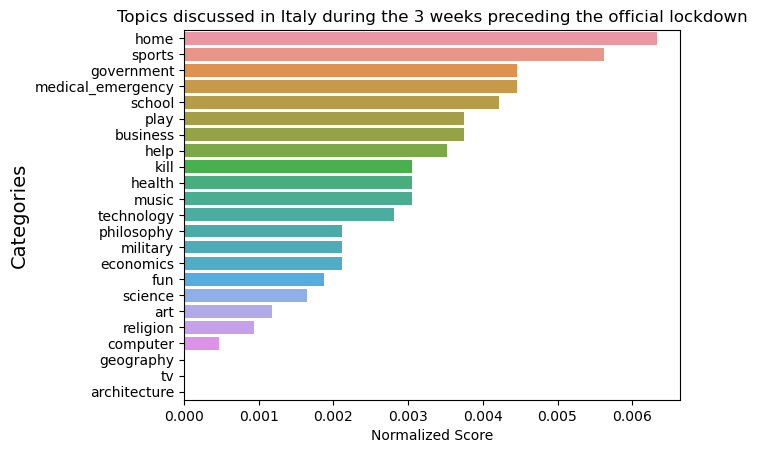

In [11]:
fig,ax = plt.subplots(1)

# We infer the topics discussed in the retrieved tweets
classified_topics = pd.DataFrame([lexicon.analyze(italian_tweets.tweet.str.cat(sep = ' '),categories = topics, 
                                                  normalize = True)], index = ['IT']).T

classified_topics = classified_topics.sort_values(by = ['IT'], ascending = False)
classified_topics.reset_index(inplace = True)
sns.barplot(data = classified_topics, x = 'IT', y = 'index')
plt.ylabel('Topics', fontsize = 14)
plt.title('Topics discussed in Italy during the 3 weeks preceding the official lockdown')
plt.ylabel('Categories')
plt.xlabel('Normalized Score')


We notice that the interest each topic receives (represented by the score) is also very similar to the number of pagelogs the very same topic received during the same period. Moreover, it is worth noticing how more discussed topics on Twitter seem to receive on average a larger number of visits in the same period: government and medical emergency, that are really close in the above graph, belong to two categories (politics and medicine) that prove to be very close also in terms of Wikipedia visits.

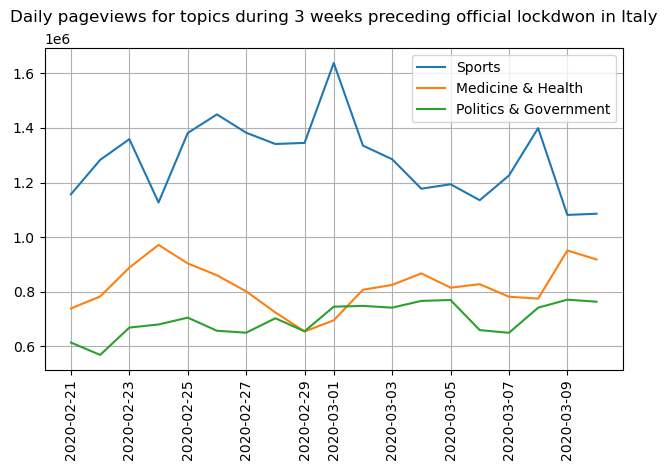

In [49]:
# We need to retrieve pageviews log from mobile and from pc
# We know that keys for mobile and not mobile are the same

keys = list(pagelogs_time_series['it']['topics']['Culture.Sports']['sum'].keys())
keys = np.array(list(map(lambda x : datetime.strptime(x.split()[0], '%Y-%m-%d'), keys)))

# Sports
sports_nm = list(pagelogs_time_series['it']['topics']['Culture.Sports']['sum'].values())
sports_m = list(pagelogs_time_series['it.m']['topics']['Culture.Sports']['sum'].values())
sports = list(map(lambda x,y : x + y, sports_nm, sports_m))

# Health
health_nm = list(pagelogs_time_series['it']['topics']['STEM.Medicine & Health']['sum'].values())
health_m = list(pagelogs_time_series['it.m']['topics']['STEM.Medicine & Health']['sum'].values())
health = list(map(lambda x,y : x + y, health_nm, health_m))

# Politics
politics_nm = list(pagelogs_time_series['it']['topics']['History and Society.Politics and government']['sum'].values())
politics_m = list(pagelogs_time_series['it.m']['topics']['History and Society.Politics and government']['sum'].values())
politics = list(map(lambda x,y : x + y, politics_nm, politics_m))

index_for_our_period = ( keys > period_per_countries['IT'][0] ) & ( keys <= period_per_countries['IT'][-1] )
keys = keys[index_for_our_period]
sports = np.array(sports)[index_for_our_period]
health = np.array(health)[index_for_our_period]
politics = np.array(politics)[index_for_our_period]
plt.plot( keys, sports, label = 'Sports')
plt.plot( keys, health, label = 'Medicine & Health')
plt.plot( keys, politics, label = 'Politics & Government')
plt.title('Daily pageviews for topics during 3 weeks preceding official lockdwon in Italy', pad = 19)
plt.xticks(rotation = 90)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

We now want to understand which emotions can be perceived from these tweets. We use an approach similar to the previous one.

Text(0.5, 0, 'Normalized Score')

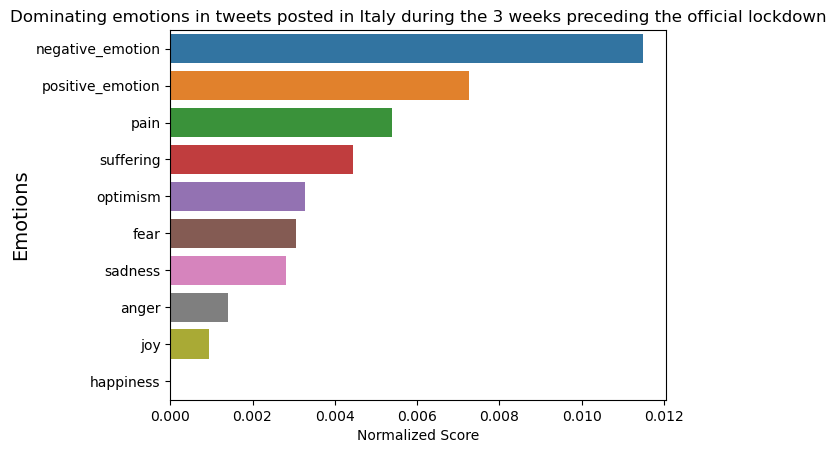

In [17]:
# We infer the topics discussed in the retrieved tweets
classified_emotions = pd.DataFrame([lexicon.analyze(italian_tweets.tweet.str.cat(sep = ' '),categories = emotions, 
                                                  normalize = True)], index = ['IT']).T

classified_emotions = classified_emotions.sort_values(by = ['IT'], ascending = False)
classified_emotions.reset_index(inplace = True)
sns.barplot(data = classified_emotions, x = 'IT', y = 'index')
plt.ylabel('Emotions', fontsize = 14)
plt.title('Dominating emotions in tweets posted in Italy during the 3 weeks preceding the official lockdown')
plt.ylabel('Emotions')
plt.xlabel('Normalized Score')


In [18]:
# Serbia
serbian_tweets = pd.read_pickle('./output/'+'RS'+'_tweets.pkl')

serbian_tweets.sample(6)

,date,id,language,tweet,tokenized_tweet_list,context_from_Twitter,polarity,subjectivity
8,2020-03-07,1236266849102422017,sr,the cornerstone for metro will take the first ...,"[the, cornerston, for, metro, will, take, the,...",[],0.250000,0.333333
32,2020-03-18,1240403881470853121,sr,luka jović is a big debill \n alooo retard one...,"[luka, jović, is, a, big, debil, alooo, retard...",[],-0.383333,0.500000
18,2020-03-13,1238497244917235712,sr,i trip to have a corona,"[i, trip, to, have, a, corona]",[],0.000000,0.000000
39,2020-03-19,1240724644807741442,sr,listen to dr kona dont make yourself smart,"[listen, to, dr, kona, dont, make, yourself, s...",[],0.214286,0.642857
1,2020-03-06,1236010834377289728,sr,i fuck his mother sometimes i really have the ...,"[i, fuck, hi, mother, sometim, i, realli, have...",[],-0.177778,0.488889
39,2020-03-04,1235279722243903489,sr,if this is not a foul during browns typing the...,"[if, thi, is, not, a, foul, dure, brown, type,...",[],0.200000,0.200000


Text(0.5, 0, 'Normalized Score')

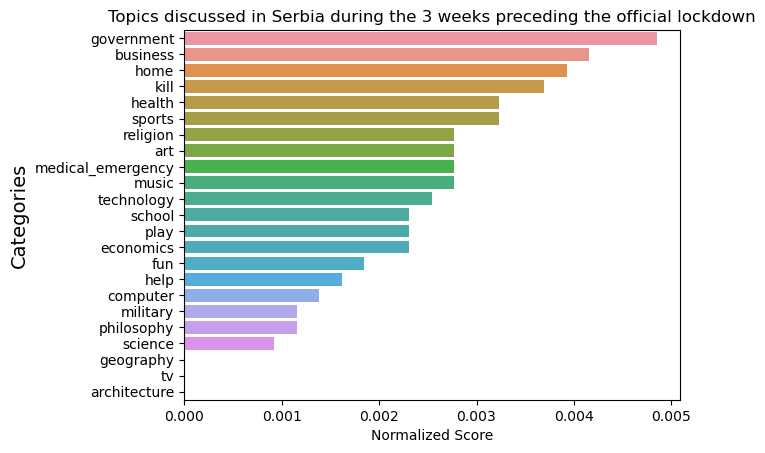

In [19]:
fig,ax = plt.subplots(1)

# We infer the topics discussed in the retrieved tweets
classified_topics = pd.DataFrame([lexicon.analyze(serbian_tweets.tweet.str.cat(sep = ' '),categories = topics, 
                                                  normalize = True)], index = ['SR']).T

classified_topics = classified_topics.sort_values(by = ['SR'], ascending = False)
classified_topics.reset_index(inplace = True)
sns.barplot(data = classified_topics, x = 'SR', y = 'index')
plt.ylabel('Topics', fontsize = 14)
plt.title('Topics discussed in Serbia during the 3 weeks preceding the official lockdown')
plt.ylabel('Categories')
plt.xlabel('Normalized Score')

From the previous plot we notice that, similarly to Italy, business and politics prove to be widely discussed topics. Moreover it is worth noticing how medical emergency covers a lower place in the final ranking. This might be due to the fact that, as intervention dates suggest, COVID-19 effects seemed to appear in Serbia later than in most of the other european countries. 1st death and 1st infection dates are very shifted if compared to the correspondng dates in other countries and this might.

In [41]:
# Importing death and infection data
data_folder = './Data/'
file_name = 'WHO-COVID-19-global-data.csv'
WHO_df = pd.read_csv(data_folder + file_name, parse_dates = ['Date_reported'])

In [42]:
# Collecting data about Italy and Serbia

df_italy = WHO_df.loc[WHO_df['Country_code']=='IT']
df_serbia = WHO_df.loc[WHO_df['Country_code']=='RS']

df_italy_interval1 = df_italy.loc[(df_italy['Date_reported']>='2020-02-20') & (df_italy['Date_reported']<='2020-03-20')]
df_serbia_interval1 = df_serbia.loc[(df_serbia['Date_reported']>='2020-02-20') & (df_serbia['Date_reported']<='2020-03-20')]

In [43]:
# Defining overall population in the countries
serbian_population = 6844000
italian_population = 59070000

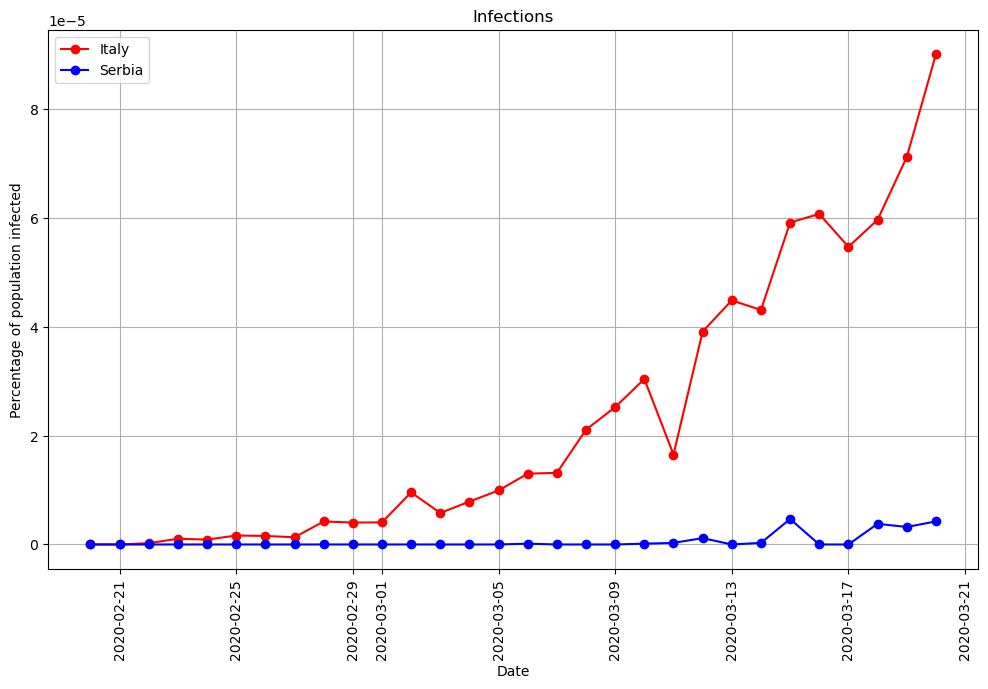

In [46]:
#
plt.figure(figsize=(12,7))
plt.plot(df_italy_interval1['Date_reported'],df_italy_interval1['New_cases']/italian_population,'-ro', label='Italy')
plt.plot(df_serbia_interval1['Date_reported'],df_serbia_interval1['New_cases']/serbian_population, '-bo', label='Serbia')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Percentage of population infected')
plt.title('Infections')
plt.xticks(rotation = 90)
plt.grid()
plt.show()

The result we had from the previous analysis can be justify by this plot. In fact we can see from it that the percentage of population that was infected in Italy and in Serbia was completely different. This could be one of the motivation why in Italy we have more discussions about *medical and health* than in Serbia. This should be investigated more in the third milestone.